PTSD modeling & exploration (`yochlol` env)

[Jump to SKIP & LOAD](#skip-&-load) if you want to skip Athena queries, loading, & cleaning and just start modeling off of 262 sessions (as of 2025-06-23)

* vary target (PTSD, Trauma, PTSD threshold, PCL regression, other questionnaires...)
* 1 task, different tasks
* make reasonable baselines
* simple features, complex features, leave 1 feature out/feature importance with sklearn/SHAP, lofo-importance lib
* compare simple faster high bias models with powerful more complex data-hungry models
* catch22 or other ts feats/tsfresh, tsflex, tsfel
* time-series-autoencoder (JulesBelveze), SimTSC (daochenzha)
* mvts transformer
* other deep learning approaches
* etc. billion other things here and elsewhere

In [1]:
import re
import os
import numpy as np
import pandas as pd
# import fireducks.pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
from tqdm import tqdm
import awswrangler as wr
#from flaml import AutoML

# import dask.array as da
# import dask.dataframe as dd

## ingest

In [2]:
def define_unique_groups(df, column="video_filename"):
    """Define grouby object and uniques, useful idiom for dataframe loop operations."""
    uniques = df[column].unique()
    grouped = df.groupby(column)
    return uniques, grouped


def label_dist(df, col="final_label"):
    #print(df.drop_duplicates('unique_id')[col].value_counts(dropna=False).sort_index())
    print(df.drop_duplicates('session_id')[col].value_counts(dropna=False).sort_index())


# load Qualtrics from aws wrangler or athena or parquet
def query_ptsd_data(query=None, database=None, debug=False) -> pd.DataFrame:
    if debug:
        # Limit query to be very small (thus fast)
        query = "SELECT DISTINCT * FROM cv LIMIT 100"

    if query is None:
        query = insight_config.QUERY

    if database is None:
        database = insight_config.DATABASE


    if insight_config.VERBOSE:
        print("Querying Athena database, this can take a few minutes...")
        # TODO: add progress bar/estimator
    df = wr.athena.read_sql_query(
        query, database=database, ctas_approach=True, chunksize=True
    )
    # NOTE: Times out for some users, chunksize=True returns tables in a flexible way, by
    # splitting the data in a Iterable of DataFrames (Memory friendly).
    # If True awswrangler iterates on the data by files in the most efficient way without
    # guarantee of chunksize."

    # concat the generator of dataframes returned by chunksize=True
    df = pd.concat(df, axis=0)

    df = df.sort_values(
        by=["session_id", "video_filename", "row_number"], ignore_index=True
    )

    # Remove test samples
    new_df = df[
        ~df["session_id"].str.contains(insight_config.TEST_SAMPLES)
    ].reset_index(drop=True)

    if insight_config.VERBOSE:
        print(f"Query returned df shape {new_df.shape}")

    save_query_df(new_df)

    return new_df


def dataset_stats(df, target="ptsd"):
    """Return unique people, sessions, and class balance stats."""
    num_people = df["unique_id"].nunique()

    if "session_id" in df.columns.to_list():
        num_sessions = df["session_id"].nunique()
    else:
        num_sessions = np.nan

    # Return pd.Series of target labels by person ("unique_id")
    # TODO: also consider by "session_id"
    class_balance = df.drop_duplicates("unique_id")[target].value_counts().sort_index()
    return num_people, num_sessions, class_balance


def print_dataset_stats(num_people, num_sessions, class_balance):
    """Convenience to hide a bunch of printing in a function.
    Useful to know during exploration & data ingestion."""
    print("---------------------------------")
    print(f"Unique People: {num_people}")
    print(f"Num Sessions: {num_sessions}")
    print(f"Class balance:\n{class_balance}")
    print("---------------------------------")


# Qualtrics
#QUERY = "select * from data_quality.qualtrics_surveys_mp"
#QUERY = "select * from data_quality.qualtrics_surveys_mp_1st_cohort"
QUERY = "select * from data_quality.qualtrics_surveys_unified"
DATABASE = "data_quality"
df = wr.athena.read_sql_query(QUERY, database=DATABASE, ctas_approach=True, chunksize=True)
# concat the generator of dataframes returned by chunksize=True
dfq = pd.concat(df, axis=0)

# df = df.sort_values(
#     by=["session_id", "video_filename", "row_number"], ignore_index=True
# )

# PCL processed
QUERY = "select * from data_quality.mp_pcl_scores"
DATABASE = "data_quality"
df = wr.athena.read_sql_query(QUERY, database=DATABASE, ctas_approach=True, chunksize=True)
dx = pd.concat(df, axis=0)


# Hermit CV & Events
#QUERY = "select * from data_quality.messy_prototyping_app_session_details where session_id = 'd0c300d6-8a13-42f2-b838-fdba7416a6ad_1746571332071'"
QUERY = "select * from data_quality.messy_prototyping_app_session_details"
DATABASE = "data_quality"
df = wr.athena.read_sql_query(QUERY, database=DATABASE, ctas_approach=True, chunksize=True)
# concat the generator of dataframes returned by chunksize=True
dfcve = pd.concat(df, axis=0)
dfcve['unique_id'] = dfcve['session_id'].apply(lambda x: x.split('_')[0])


# Quality stuff
QUERY = "select session_id, problem from data_quality.master_query_session_completion_check where problem = 'none' and study_location = 'Messy Prototyping'"
DATABASE = "data_quality"
df = wr.athena.read_sql_query(QUERY, database=DATABASE, ctas_approach=True, chunksize=True)
df_quality = pd.concat(df, axis=0)
# df = df.sort_values(
#     by=["session_id", "video_filename", "row_number"], ignore_index=True
# )


# Check that qualtrics and CV/events are equal size
try:
    assert dfq['order_uuid'].nunique() == dfq['session_id'].nunique(), "Unequal session & order id"
except AssertionError as e:
    if dfq['order_uuid'].nunique() < dfq['session_id'].nunique():
        print("More sessions than order ids. Repeat sessions?")
assert dfcve['session_id'].nunique() == dfcve['session_id'].nunique(), "Unequal session & order id"
assert dx['session_id'].nunique() == dx['session_id'].nunique(), "Unequal session & order id"

KeyboardInterrupt: 

CV & PCL intersection: 267
+ Qualtrics: 267


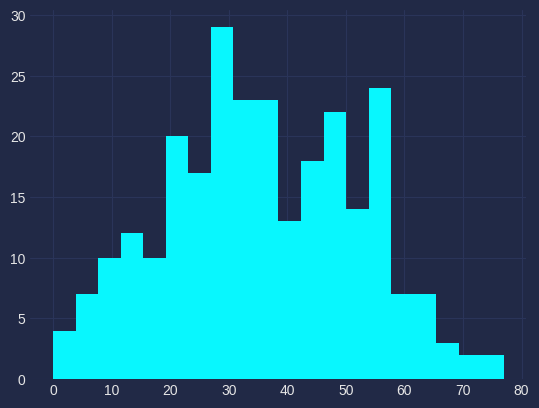

ptsd_bin
0    126
1    141
Name: count, dtype: int64

In [3]:
sessions_to_use = df_quality['session_id'].unique().tolist()


dfq = dfq[dfq['session_id'].isin(sessions_to_use)].reset_index(drop=True)
dfcve = dfcve[dfcve['session_id'].isin(sessions_to_use)].reset_index(drop=True)
dx = dx[dx['session_id'].isin(sessions_to_use)].reset_index(drop=True)

# Filter intersection of all 3
q, c, x = dfq['session_id'].unique(), dfcve['session_id'].unique(), dx['session_id'].unique()
q, c, x = set(q), set(c), set(x)
intersection = c & x
print(f"CV & PCL intersection: {len(intersection)}")
final_session_list = list(q & intersection)
print(f"+ Qualtrics: {len(final_session_list)}")

dfq = dfq[dfq['session_id'].isin(final_session_list)].reset_index(drop=True)
dfcve = dfcve[dfcve['session_id'].isin(final_session_list)].reset_index(drop=True)
dx = dx[dx['session_id'].isin(final_session_list)].reset_index(drop=True)

assert dfq['session_id'].nunique() == dfcve['session_id'].nunique() == dx['session_id'].nunique()

# Binary labels
dx['ptsd_bin'] = dx['ptsd'].map({"Negative": 0, "Positive": 1})
dx['ptsd_bin'].value_counts(dropna=False)

dx['pcl_score'].hist(bins=20)
plt.show()

dx['ptsd_bin'].value_counts(dropna=False).sort_index()

In [4]:
REMOVE_INTERMEDIATE = False # True
PTSD_THRESHOLD = 33
BUFFER = 8 # 8 = (25, 41)

if REMOVE_INTERMEDIATE:
    dxx = dx[~dx['pcl_score'].between(PTSD_THRESHOLD-BUFFER, PTSD_THRESHOLD+BUFFER, inclusive='both')]
    print(dxx['ptsd_bin'].value_counts(dropna=False).sort_index())

    dxx['pcl_score'].hist(bins=20)
    plt.show()


# TODO: apply to actual dx and filter if you want to go this way

### survey wrangling (LEC, depression, anxiety, etc.)

In [5]:
# for later

### CV & event wrangling

In [5]:
# TODO: drop List Learning / .m4a / audio from dataframe, it has no CV/timeseries
idx_LL = dfcve['task_id'].str.contains("list_learning")
dfcve = dfcve[~idx_LL]
# TODO: replace later with tabular data

# Order
dfcve = dfcve.sort_values(by=['session_id', 'frametimestamps']).reset_index(drop=True)

In [6]:
dfcve.shape, dfcve['session_id'].nunique()

((16253257, 42), 267)

##### grab phone info (no 12, no minis) SKIP if error

In [8]:
# Grab phone model & app version and join with cv/events
#QUERY = "select * from data_quality.messy_prototyping_tracker" # error prone `QueryFailed: INVALID_CAST_ARGUMENT`, `user` BIGINT issue
QUERY = "select session_id, version_name, phone_model from data_quality.messy_prototyping_tracker"
DATABASE = "data_quality"

#df = wr.athena.read_sql_query(QUERY, database=DATABASE, ctas_approach=True, chunksize=True)
df = wr.athena.read_sql_query(QUERY, database=DATABASE, ctas_approach=False, chunksize=True)
db = pd.concat(df, axis=0)

# strip to only match sessions; cary over specific columns
db = db[db['session_id'].isin(final_session_list)][['session_id', 'phone_model', 'version_name']]

EXCLUDE_PHONES = ["?unrecognized?", "iPhone 13 Mini"]
db = db[~db['phone_model'].isin(EXCLUDE_PHONES)]
db = db[~db['phone_model'].str.contains("Mini")]

# merge phone type with event/cv df
dfcve = db.merge(dfcve, how='inner', on='session_id').reset_index(drop=True)

In [9]:
final_session_list = dfcve['session_id'].unique()
dfcve.shape, dfcve['session_id'].nunique()

((15976422, 44), 262)

### rename tasks

In [10]:
# parse task name unifier

def get_task_names_map():
    """Return mapping use to unify various names for each task"""
    return {
        # "plr_view": "plr",
        # "PLR": "plr",
        "aiv": "affective_image_set",
        "ptsd_image_set": "affective_image_set",
    }


def fix_task_names(df: pd.DataFrame) -> pd.DataFrame:
    """Returns df with new task_id_renamed column with old intact.

    Effectively, removes block numbers and other inconsistent naming practices.
    """

    task_dict = get_task_names_map()
    new_df = df.copy()

    # Must create new column each renaming step.
    # Re-running on same column overwrites ALL values, effectively only running that line
    new_df["renamed_0"] = new_df["task_id"].str.replace( # plr_x -> plr
        r".*plr.*", "plr", flags=re.IGNORECASE, regex=True
    )
    new_df["renamed_1"] = new_df["renamed_0"].replace(task_dict) # tasks in task dict
    new_df["renamed_2"] = new_df["renamed_1"].str.replace( # aiv block removal
        r".*affective.*", "affective_image_set", regex=True
    )
    new_df["renamed_3"] = new_df["renamed_2"].str.replace(
        r".*face_pairs.*", "face_pairs", regex=True
    )
    new_df["renamed_4"] = new_df["renamed_3"].str.replace(
        r".*mckinnon.*", "mckinnon", regex=True
    )
    new_df["renamed_5"] = new_df["renamed_4"].str.replace(
        r".*list_learning.*", "list_learning", regex=True
    )

    new_df["task_id_renamed"] = new_df["renamed_5"].str.replace(
        r".*attention.*", "attention_bias", flags=re.IGNORECASE, regex=True
    )
    # TODO: check other dot stuff like events


    del new_df["renamed_0"]
    del new_df["renamed_1"]
    del new_df["renamed_2"]
    del new_df["renamed_3"]
    del new_df["renamed_4"]
    del new_df["renamed_5"]

    # Test for misses (additional tasks beyond this will result in False)
    REFERENCE = [
        "plr",
        "calibration_1",
        "calibration_2",
        # "attention_bias",
        "face_pairs",
        # "affective_image_set",
        "mckinnon",
        "list_learning"
    ]
    tasks = new_df["task_id_renamed"].value_counts().index.to_list()
    assert all(t in REFERENCE for t in tasks)

    return new_df

dfcve2 = fix_task_names(dfcve)
dfcve2 = dfcve2.dropna(subset='frametimestamps', axis=0).reset_index(drop=True)

In [11]:
dfcve2.shape, dfcve2['session_id'].nunique()

((15953350, 45), 262)

In [13]:
def no_nans(series: pd.Series):
    return (series.isna()).sum() == 0

# nan check
assert no_nans(dfcve2['session_id'])
#assert no_nans(dfcve2['video_path'])
assert no_nans(dfcve2['row_number']) # bypass
assert no_nans(dfcve2['frametimestamps'])

#sorted_df = dfcve2.sort_values(by=['session_id', 'frametimestamps']) # already sorted, pushed nans to end

#### encode tasks (skip for now)
(once Michael C's work is integrated across qualtrics, UI, and Research/`dot`)

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

cols = [
    "task_id",
    "event_name",
    "event_type",
    "condition",
    "top_emotion",
    "bottom_emotion",
    "cue_location",
    "dot_location",
    "incongruency",
    "engage_disengage",
]

# # time wtf: row_number, timestamps can be out of order,.... why?

# # TODO:
# # / handcrafted
# # / one hot
# # / assign to df wrangling
# # - match prod col names/organization

# various_time_cols = [  # for reference. delete once built
#     "frame_timestamps",
#     "frametimestamps",
#     "video_frametimestamps",
#     "row_number",
# ]

# ONEHOT_MAP = {  # for ref
#     "task": [0, 1, 2, 3],  # cal, plr, mab, mck
#     "mab_engagement / mck_phase": [0, 1, 2],
#     "mab_emotion / mck_emotion": [0, 1, 2, 3],
#     "mab_emo_location / mck subcat": [0, 1],
#     "mab_dot_location": [0, 1],
#     "mab_cue_location": [0, 1],
# }


def encode_task_handcrafted(df: pd.DataFrame, task="mab") -> np.array:
    df = df[df["task"] == task].copy()
    print(df)
    n_rows = df.shape[0]

    # maps
    MAB_MAP = {
        "engagement": {"disengagement": 0, "engagement": 1},
        "emotion": {"neutral": 0, "happy": 1, "sad": 2, "angry": 3},
        "emo_location": {"bottom": 0, "top": 1},
        "dot_location": {"bottom": 0, "top": 1},
        "cue_location": {"bottom": 0, "top": 1},
    }

    MCKINNON_MAP = {
        "phase": {"fixation": 0, "image": 1, "blank": 2},
        "emotion": {"positive": 0, "negative": 1, "neutral": 2, "negative_arousal": 3},
        "subcategory": {},
    }

    # checks
    def check_length(encoding, n_rows):
        return encoding.shape[0] == n_rows

    # parse task
    match task:
        case "calibration":
            enc = np.zeros(6, dtype=np.uint8)
            enc = np.tile(enc, (n_rows, 1))
            assert check_length(enc, n_rows)
            return enc

        case "plr":
            enc = np.zeros(6, dtype=np.uint8)
            enc[0] = 1
            enc = np.tile(enc, (n_rows, 1))
            assert check_length(enc, n_rows)
            return enc

        case "mab":
            enc = np.zeros(6, dtype=np.uint8)
            enc[0] = 2
            enc = np.tile(enc, (n_rows, 1))
            enc[:, 1] = df["mab_engagement"].apply(lambda x: MAB_MAP["engagement"][x])
            enc[:, 2] = df["mab_emotion"].apply(lambda x: MAB_MAP["emotion"][x])
            enc[:, 3] = df["mab_emo_location"].apply(
                lambda x: MAB_MAP["emotion_location"][x]
            )
            enc[:, 4] = df["mab_dot_location"].apply(
                lambda x: MAB_MAP["dot_location"][x]
            )
            enc[:, 5] = df["mab_cue_location"].apply(
                lambda x: MAB_MAP["cue_location"][x]
            )
            assert check_length(enc, n_rows)
            return enc

        case "mckinnon":
            enc = np.zeros(6, dtype=np.uint8)
            enc[0] = 3
            enc = np.tile(enc, (n_rows, 1))
            enc[:, 1] = df["mck_phase"].apply(lambda x: MCKINNON_MAP["phase"][x])
            enc[:, 2] = df["mck_emotion"].apply(lambda x: MCKINNON_MAP["emotion"][x])
            # enc[:, 3] = df["mck_subcategory"].apply(lambda x: MCKINNON_MAP["subcategory"][x])
            assert check_length(enc, n_rows)
            return enc

        case _:
            raise ValueError(f"'{task}' task not recognized")


def encode_task_onehot(df: pd.DataFrame, task="mab") -> pd.DataFrame:
    df = df[df["task"] == task].copy()
    n_rows = df.shape[0]

    # checks
    def check_length(encoding, n_rows):
        return encoding.shape[0] == n_rows

    # maps
    MAB_MAP = {
        "engagement": {"disengagement": 0, "engagement": 1},
        "emotion": {"neutral": 0, "happy": 1, "sad": 2, "angry": 3},
        "emotion_location": {"bottom": 0, "top": 1},
        "dot_location": {"bottom": 0, "top": 1},
        "cue_location": {"bottom": 0, "top": 1},
    }

    task_1hot = OneHotEncoder(
        categories=[["calibration", "plr", "mab", "mckinnon"]], sparse_output=False
    )

    # parse task
    match task:
        case "calibration":
            # init 1hot dataframe
            output_columns = pd.DataFrame(columns=["task_1hot"])
            # set task column first
            output = task_1hot.fit_transform(df["task"].values.reshape(-1, 1))
            output = pd.Series(list(output))
            output_columns["task_1hot"] = output
            # reindex to match for merging
            output_columns = output_columns.set_index(df.index)
            assert check_length(output_columns, n_rows)
            return output_columns

        case "plr":
            # init 1hot dataframe
            output_columns = pd.DataFrame(columns=["task_1hot"])
            # set task column first
            output = task_1hot.fit_transform(df["task"].values.reshape(-1, 1))
            output = pd.Series(list(output))
            output_columns["task_1hot"] = output
            # reindex to match for merging
            output_columns = output_columns.set_index(df.index)
            assert check_length(output_columns, n_rows)
            return output_columns

        case "mab":
            encoders = {
                "mab_engagement": OneHotEncoder(
                    categories=[["disengagement", "engagement"]], sparse_output=False
                ),
                "mab_emotion": OneHotEncoder(
                    categories=[["neutral", "happy", "sad", "angry"]],
                    sparse_output=False,
                ),
                "mab_emo_location": OneHotEncoder(
                    categories=[["bottom", "top"]], sparse_output=False
                ),
                "mab_dot_location": OneHotEncoder(
                    categories=[["bottom", "top"]], sparse_output=False
                ),
                "mab_cue_location": OneHotEncoder(
                    categories=[["bottom", "top"]], sparse_output=False
                ),
            }

            # init 1hot dataframe
            col_list = list(encoders.keys())
            col_list.insert(0, "task_1hot")
            output_columns = pd.DataFrame(columns=col_list)

            # set task column first
            output = task_1hot.fit_transform(df["task"].values.reshape(-1, 1))
            output = pd.Series(list(output))
            output_columns["task_1hot"] = output

            # loop through the other hierarchical 1hot encoders and add to columns
            for col, encoder in encoders.items():
                output = encoder.fit_transform(df[col].values.reshape(-1, 1))
                output = pd.Series(list(output))
                output_columns[col + "_1hot"] = output
                del output_columns[col]
            output_columns = output_columns.set_index(df.index)
            assert check_length(output_columns, n_rows)
            return output_columns

        case "mckinnon":
            encoders = {
                "mck_phase": OneHotEncoder(
                    categories=[["fixation", "image", "blank"]], sparse_output=False
                ),
                "mck_emotion": OneHotEncoder(
                    categories=[
                        ["positive", "negative", "neutral", "negative_arousal"]
                    ],
                    sparse_output=False,
                ),
                # "mck_subcategory": OneHotEncoder(
                #     categories=[[""]], sparse_output=False
                # ),
            }

            # init 1hot dataframe
            col_list = list(encoders.keys())
            col_list.insert(0, "task_1hot")
            output_columns = pd.DataFrame(columns=col_list)

            # set task column first
            output = task_1hot.fit_transform(df["task"].values.reshape(-1, 1))
            output = pd.Series(list(output))
            output_columns["task_1hot"] = output

            # loop through the other hierarchical 1hot encoders and add to columns
            for col, encoder in encoders.items():
                output = encoder.fit_transform(df[col].values.reshape(-1, 1))
                output = pd.Series(list(output))
                output_columns[col + "_1hot"] = output
                del output_columns[col]
            output_columns = output_columns.set_index(df.index)
            assert check_length(output_columns, n_rows)
            return output_columns

        case _:
            raise ValueError(f"'{task}' task not recognized")


In [ ]:
##############################################
# EXAMPLE USE - SETUP

task_cols = [
    "task",
    "mab_engagement",
    "mab_emotion",
    "mab_emo_location",
    "mab_dot_location",
    "mab_cue_location",
    "mck_phase",
    "mck_emotion",
]

task_df = df[task_cols].copy()
# print(task_df)

# df["task_encoding"] = encode_task_handcrafted(task_df, task="task")

# # ----- HANDCRAFTED -----
# task_df["task_encoding"] = np.nan
# task_df["task_encoding"] = task_df["task_encoding"].astype(object)

# enc_vector = encode_task_handcrafted(task_df, task=TASK)
# mask = task_df["task"] == TASK
# assert mask.sum() == enc_vector.shape[0]

# # Assign row by row (inefficient but ok loop)
# # for idx, encoding in zip(task_df[mask].index, enc_vector):
# #     task_df.at[idx, "task_encoding"] = encoding

# # Pandas idiomatic (better assuming indexes align...)
# enc_series = pd.Series(list(enc_vector), index=task_df[mask].index)
# task_df.loc[enc_series.index, "task_encoding"] = enc_series
# print(task_df)


    # ----- ONEHOT -----
print(task_df)

enc_df = encode_task_onehot(task_df, task="mab")
print(enc_df)

# NOTE: replace task_df with original df once tested

# NOTE: MAB & McKinnon only
for col in enc_df.columns:
    if col not in task_df.columns:
        task_df[col] = pd.NA
task_df.update(enc_df, overwrite=False, errors="raise")
print(task_df)
print(task_df["task_1hot"])

enc_df = encode_task_onehot(task_df, task="calibration")
print(enc_df)
task_df.update(enc_df, overwrite=False, errors="raise")
print(task_df)
print(task_df["task_1hot"])

enc_df = encode_task_onehot(task_df, task="plr")
print(enc_df)
task_df.update(enc_df, overwrite=False, errors="raise")
print(task_df)
print(task_df["task_1hot"])

enc_df = encode_task_onehot(task_df, task="mckinnon")
print(enc_df)
# NOTE: MAB & McKinnon only
for col in enc_df.columns:
    if col not in task_df.columns:
        task_df[col] = pd.NA
task_df.update(enc_df, overwrite=False, errors="raise")
print(task_df)
print(task_df[["mck_phase", "mck_emotion", "mck_phase_1hot", "mck_emotion_1hot"]])
print(task_df["task_1hot"])

## check final cv df after cleaning, task renaming & encoding

In [ ]:
#dfcve2.shape, dfcve2['session_id'].nunique()

## merge targets/surveys with cv & events

In [14]:
labels = dx[['session_id', 'pcl_score', 'ptsd_bin']]

df = labels.merge(dfcve2, how='inner', on='session_id')

print(df.shape, df['session_id'].nunique())
#df.drop_duplicates('session_id')['ptsd_bin'].value_counts(dropna=False)
label_dist(df, col='ptsd_bin')

(15953350, 47) 262
ptsd_bin
0    124
1    138
Name: count, dtype: int64


In [ ]:
# TODO NEXT: remove first 3000ms of "get ready" (CAN'T BE BASED ON FPS, BUT TIME)
#CHOP_OFF_ms = 3000  # first 3000 ms are "get ready", or `event_name``
df2 = df[~df['event_name'].str.contains("get ready")].reset_index(drop=True)

In [16]:
df2.shape, df2['session_id'].nunique(), label_dist(df2, col='ptsd_bin')

ptsd_bin
0    124
1    138
Name: count, dtype: int64


((15472232, 47), 262, None)

# SKIP & LOAD
start here to load a processed parquet file and skip the queries (262 sessions as of 2025-06-23)

In [2]:
import re
import os
import numpy as np
import pandas as pd
# import fireducks.pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')
from tqdm import tqdm
import awswrangler as wr
#from flaml import AutoML

# import dask.array as da
# import dask.dataframe as dd


def define_unique_groups(df, column="video_filename"):
    """Define grouby object and uniques, useful idiom for dataframe loop operations."""
    uniques = df[column].unique()
    grouped = df.groupby(column)
    return uniques, grouped


def label_dist(df, col="final_label"):
    #print(df.drop_duplicates('unique_id')[col].value_counts(dropna=False).sort_index())
    print(df.drop_duplicates('session_id')[col].value_counts(dropna=False).sort_index())


# # save for team to use
# savepath = "/data/datasets/source/ptsd/"
# filename = "MP_262_joined.parquet"
# df2.to_parquet(os.path.join(savepath, filename))

# LOAD
df2 = pd.read_parquet("/data/datasets/source/ptsd/MP_262_joined.parquet")

# NOTE: you'll have to rerun the queries & processing above instead once we get new people

In [3]:
df2.shape, df2['session_id'].nunique(), label_dist(df2, col='ptsd_bin')

ptsd_bin
0    124
1    138
Name: count, dtype: int64


((15472232, 47), 262, None)

# ELT pipe cleaning & EDA

In [ ]:
# from typing import Tuple

# def test_no_duplicates(df: pd.DataFrame, identifier: str):
#     """Test df for common duplications/collisions after wrangling.

#     NOTE: Intended use is on a dataframe (or df subset) corresponding
#     to 1 unique id, 1 session, 1 video. Otherwise will hang.

#     df : dataframe

#     identifier : str
#         video filename, unique_id, session_id, etc

#     """
#     assert df["unique_id"].nunique() == 1
#     assert df["session_id"].nunique() == 1
#     assert df["video_filename"].nunique() == 1
#     try:
#         assert df["uploaded_at"].nunique() == 1
#     except AssertionError:
#         unique_count = df["uploaded_at"].nunique()
#         print(
#             f'{unique_count} uniques in column "uploaded_at" in {identifier}. Expected 1, using first index'
#         )

#     # If this fails, it means the unique_id has 2 different PTSD labels
#     try:
#         assert df["ptsd"].nunique() == 1
#     except:
#         if df["ptsd"].isna().sum() > 0:
#             print("NaNs detected in labels")
#         else:
#             raise Exception("dataframe has multiple ptsd labels")


# def norm_and_interpolate(data, num_samples) -> np.ndarray:
#     """Normalize and interpolate a signal.

#     "Normalize" in this context means 0 mean, 1 standard dev.

#     data : np.ndarray
#         rows as observations, columns as features (1 col is a timeseries)

#     num_samples : int
#         desired length of output signal
#     """
#     data = (data - data.mean(axis=0)) / data.std(axis=0)
#     intrp = torch.from_numpy(data)
#     data_interp = (
#         F.interpolate(intrp.unsqueeze(0).unsqueeze(0), num_samples).squeeze().numpy()
#     )
#     return data_interp


# def shortest_video_samples(timeseries_df: pd.DataFrame, task: str) -> int:
#     """Return the number of samples of the shortest video in your dataframe.

#     Assumes same task (PLR, affective img, cal, etc.), otherwise,
#     YOUR VIDS COULD BE CUT WAY TOO SHORT!

#     timeseries_df : dataframe with your timeseries
#     task : str like "plr" or "calibration"
#     """
#     task_samples = {
#         "affective_image_set": 2400,
#         "plr": 1200,
#         "calibration_1": 3300,
#         "calibration_2": 3300,
#     }
#     num_samples = task_samples.get(task, None)

#     # Find shortest video
#     videos, grouped = define_unique_groups(timeseries_df, column="video_filename")
#     for vid in videos:
#         temp = grouped.get_group(vid).sort_values("row_number").reset_index(drop=True)
#         # uid = temp['unique_id'].unique()[0]

#         if temp.shape[0] < num_samples:
#             num_samples = temp.shape[0]

#     return num_samples


# def wrangle_timeseries(
#     df, features=None, task=None, deblink=insight_config.DEBLINK
# ) -> pd.DataFrame:
#     """Prep timeseries data for loading into models.

#     This includes trunacting time series, resampling, standardizing/normalizing, & deblinking.

#     df : dataframe to process
#     features : list of strings
#         column names of features to include in model
#     task : str or list of strings
#         names of tasks to include e.g. PLR, calibration, ptsd images, etc.
#     deblink : boolean
#         deblink the timeseries or not

#     """

#     if features is None:
#         features = insight_config.FEATS

#     # Filter df to specific task(s) and feature set
#     if insight_config.VERBOSE:
#         print(f"Filtering to {task}")
#     timeseries_df = df[df["task_id_renamed"] == task].reset_index(drop=True)
#     timeseries_df = timeseries_df[features + insight_config.UTIL_COLS]

#     # Value to truncate samples to
#     shortest_timeseries = shortest_video_samples(timeseries_df, task)
#     if insight_config.VERBOSE:
#         print(f"Truncating {task} to {shortest_timeseries} samples")

#     # Resample all to be same length, Normalize, & Repack into new DataFrame
#     videos, grouped = define_unique_groups(timeseries_df, column="video_filename")
#     df_collector = []
#     for vid in videos:
#         temp = grouped.get_group(vid).sort_values("row_number").reset_index(drop=True)

#         # Test for common duplication issues in preprocessing
#         # and Get values for this iteration subset
#         test_no_duplicates(temp, vid)
#         uid = temp["unique_id"].iloc[0]
#         sess = temp["session_id"].iloc[0]
#         upload_time = temp["uploaded_at"].iloc[0]
#         ptsd_status = temp["ptsd"].iloc[0]

#         # Resample & Normalize timeseries
#         # NEED TO RESAMPLE BEFORE IF IMPLEMENTING DEBLINKING - check sampling rate for deblinker
#         data = temp[features].values
#         transformed_data = []
#         for column_idx in range(data.shape[1]):
#             column = data[:, column_idx].copy().astype("float")
#             # TODO: investigate why converstion to `float` is needed.
#             # original Err: coming up with type `numpy.object_` that norm_interp() couldn't process
#             tmp = norm_and_interpolate(column, shortest_timeseries)
#             transformed_data.append(tmp)
#         new_data = np.array(transformed_data).T
#         # new_data = np.array(transformed_data).reshape((shortest_timeseries, len(FEATURE_SET)))
#         # new_data = np.concatenate(transformed_data).reshape((shortest_timeseries, len(FEATURE_SET)))

#         ndf = pd.DataFrame(data=new_data, columns=features)

#         # New df columns
#         ndf["unique_id"] = uid
#         ndf["session_id"] = sess
#         ndf["video_filename"] = vid
#         ndf["uploaded_at"] = upload_time
#         ndf["ptsd"] = ptsd_status

#         # Collect eye features from each video
#         df_collector.append(ndf)

#     prepped_df = pd.concat(df_collector, axis=0).reset_index(drop=True)
#     if insight_config.VERBOSE:
#         print(f"Timeseries wrangled from {features}")
#         print(f"shape: {prepped_df.shape}")
#         print(f"df columns:\n{prepped_df.columns.to_list()}")
#     return prepped_df


##### length issue wtf

In [143]:
60*14*5.8, 60*14*6.5

(4872.0, 5460.0)

mckinnon
mean: 1408.958932238193
med: 1477.0


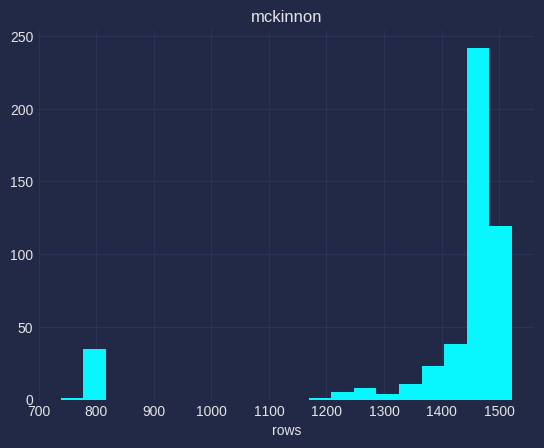

In [151]:
# Check lengths for all types of tasks

rough_vid_min = { # 60fps
    "calibration_1": 1650, # 27.5 s
    "calibration_2": 1650,
    "plr": 480, # 8 s
    "face_pairs": 5460, # 5.8-6.5 sec * 14
    "mckinnon": 1440 # 24 s
}



all_tasks = df2['task_id_renamed'].unique()

for task in all_tasks:
    #if task == 'calibration_1':
    #if task == 'calibration_2':
    #if task == 'plr':
    #if task == 'face_pairs': #NOTE: couple very long, wtf
    if task == 'mckinnon':
        print(task)
        vid_length = []
        vids, dfg = define_unique_groups(df2[df2['task_id_renamed'] == task], column="video_path")
        for v in vids:
            tmp = dfg.get_group(v)
            assert tmp['task_id_renamed'].iloc[0] == task

            # TODO: drop lowest fps videos
            # print(tmp['frametimestamps'].diff().value_counts().sort_index())

            #max_frame_interval = tmp['frametimestamps'].diff().value_counts().sort_index().index.max()
            # if max_frame_interval > 20: # < 50 fps
            #     pass # drop
            # TODO: NEXT: why PLR fucked? check fps/0-intervals

            # if tmp.shape[0] < rough_vid_min[task]:
            #     print(tmp['session_id'].unique())
            #     print(tmp['video_path'].unique())

            vid_length.append(tmp.shape[0])

        vid_length = np.array(vid_length)
        print(f"mean: {vid_length.mean()}")
        print(f"med: {np.median(vid_length)}")

        pd.Series(vid_length).hist(bins=20)
        plt.title(task)
        plt.xlabel("rows")
        plt.show()

In [153]:
df2['phone_model'].value_counts(dropna=False).sort_index()

KeyError: 'phone_model'

In [ ]:
dataset = wrangle_timeseries(
    dataset,
    features=FEATS,
    task=TASK,
    deblink=DEBLINK,
)

In [26]:
FEATS = [
    'pupil_area_right',
    'pupil_area_left',
    'pupil_centers_right_x',
    'pupil_centers_right_y',
    'pupil_centers_left_x',
    'pupil_centers_left_y',
    'pirl',
    'pirr',
    'gaze_pupil_centers_left_y',
    'gaze_pupil_centers_left_x',
    'gaze_pupil_centers_right_y',
    'gaze_pupil_centers_right_x',
    'gaze_left_pitch',
    'gaze_left_yaw',
    'gaze_right_pitch',
    'gaze_right_yaw',
    'head_pitch',
    'head_yaw',
    'head_roll',
    'pupil_area_right_interpolate',
    'pupil_area_left_interpolate',
    'pupil_centers_right_x_interpolate',
    'pupil_centers_right_y_interpolate',
    'pupil_centers_left_x_interpolate',
    'pupil_centers_left_y_interpolate',
]

In [27]:
cols = dfcve2.columns.to_list()
for f in FEATS:
    if f not in cols:
        print(f)

gaze_pupil_centers_left_y
gaze_pupil_centers_left_x
gaze_pupil_centers_right_y
gaze_pupil_centers_right_x
gaze_left_pitch
gaze_left_yaw
gaze_right_pitch
gaze_right_yaw
head_pitch
head_yaw
head_roll
pupil_area_right_interpolate
pupil_area_left_interpolate
pupil_centers_right_x_interpolate
pupil_centers_right_y_interpolate
pupil_centers_left_x_interpolate
pupil_centers_left_y_interpolate


In [ ]:
# TODO: NEXT prep timeseries for model ingestion

In [33]:
dfcve2.columns.to_list()

['session_id',
 'task_id',
 'video_path',
 'block_number',
 'event_order',
 'event_name',
 'event_start',
 'event_end',
 'block_trial',
 'trial',
 'category',
 'event_category',
 'event_type',
 'displayed_cal_dot_at_x',
 'displayed_cal_dot_at_y',
 'item',
 'list_type',
 'row_number',
 'frametimestamps',
 'pupil_area_left',
 'pupil_area_right',
 'pupil_centers_left_x',
 'pupil_centers_left_y',
 'pupil_centers_right_x',
 'pupil_centers_right_y',
 'pirl',
 'pirr',
 'task_id_renamed']

# normalize/standardize, truncate, resample, etc.

In [ ]:
# normalize

# don't bother with unsupervised for now
# get timeseries same length / de-ragged

# # DummyClassifier

In [ ]:
# DETRENDER
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

transformer = Detrender(forecaster=PolynomialTrendForecaster(degree=3))
data = transformer.fit_transform(pd.Series(data))

# or scipy version
from scipy.signal import detrend
const = detrend(x, type='constant')
linear = detrend(x, type='linear')

# numpy polynomial
DEGREE = 3
poly_n = np.polynomial.Polynomial.fit(x, y, deg=DEGREE)


# task picker (one, combo, all?)

In [ ]:
# this or OneHot?

def factorize_categorical_column(df, col_name="unique_id") -> pd.DataFrame:
    """Add a new df column that converts the desired column to a numerical category.
    `pd.factorize()` alone encodes the object as an enumerated type or categorical
    variable.

    Example: run on `unique_id` column of dataframe for leave-one-person-out
        cross-validation, so that unique ids are ordered 0, 1, 2, ... instead
        of string literal `unique_id`s.
    """
    new_df = df.copy()
    new_col_name = "factorized_" + col_name
    new_df[new_col_name] = pd.factorize(new_df[col_name])[0]
    return new_df

# convert task to factorized feat; TODO: OneHot once McKinnon done by Research
# df = factorize_categorical_column(df, col_name="task")

# Modeling start

# * ROCKET stuff, `tsai`

In [ ]:
# ROCKET stuff (optimized/chunked for large datasets), plus ridge regressor and xgb/lgbm

# catboost?

# tsai (HC2, ts-chief, inception time)
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.hybrid.HIVECOTEV2.html

# hydra (angus924) repo
# or HYDRA + SelF-Rocket

In [ ]:
import torch

from tsai.models.MINIROCKET_Pytorch import MiniRocketFeatures, get_minirocket_features
from tsai.data import validation
from tslearn.utils import to_time_series_dataset
from tsai.all import *

# def nullify_indices(properties):
#     l = list(zip(properties['left_ips'], properties['right_ips']))
#     nulx = []
#     for e in l:
#         if (int(e[1]) - int(e[0])) > 300:
#             continue
#         nulx += list(np.arange(int(e[0]), int(e[1])))
#     return np.array(list(set(nulx)))


# def nullify_blinks(tmp, nulc=['pupil_area_left', 'pupil_area_right']):
#     tmpp = tmp.copy()
#     foo = tmpp[['iris_area_left', 'iris_area_right']].copy()
#     data = foo.mean(1).rolling(3).mean().fillna(method='bfill')
#     data = (data - data.mean()).abs()
#     x = data.values / data.values.max()

#     peaks, properties = find_peaks(x, prominence=(0.4, None), height=0.3, distance=16, width=(None,300))
#     results_half = peak_widths(x, peaks, rel_height=0.85)
#     results_full = peak_widths(x, peaks, rel_height=1)
#     properties["width_heights"] = results_half[1]
#     properties["left_ips"] = results_half[2]
#     properties["right_ips"] = results_half[3]

#     nulx = nullify_indices(properties)
#     tmpp.loc[nulx, nulc] = np.nan
#     return tmpp

def get_tsdfs(unique_items, dfg, tscols):#categorical=False):
    """
    Returns np.ndarray of time series given gropuby obj and unique items.

    Args:
    -----
    unique_items : list of uniques, like session, video path, etc.
    dfg : pd.DataFrame groupby object associated with unique items
    tscols : list of df column names to include
    categorical : [DEPRECATED] whether to process categorical or not

    Returns:
    --------
    x : numpy array of time series

    """
    df_assembler = []

    for u in tqdm(unique_items):
        tmp = dfg.get_group(u).reset_index(drop=True)
        df_assembler.append(tmp[tscols])
        # append time series or categorical columns
        # categorical for rocket feats, need to factorize if so
        #df_assembler.append(tmp[tscol] if not categorical else tmp[ycols])
    # to_time_series_dataset() will put everything together into
    # a square array for you by padding everything to the length
    # of the longest single sequence
    # but check.....might add a ton of 0 padding
    tsd = to_time_series_dataset(df_assembler)
    x = torch.from_numpy(tsd).permute(0,2,1).numpy()
    return x

def get_mrfs(X, splits, num_kernels=10000):
    """
    Get MiniRocketFeatures in one convenient function.

    Args:
    -----
    X : data in, torch.Tensor of shape (batchsize, channels, length)
    splits : tuple, split idx for data, from tsai.data.validation.get_splits()
    num_kernels : int, desired number of rocket kernels

    Returns:
    --------
    X_feat : np.ndarray, minirocket features of shape (batchsize, rocket kernels, 1)
    mrf : fitted MiniRocketFeatures model instance

    """
    #mrf = MiniRocketFeatures(xXx.shape[1], xXx.shape[2]).to(torch.device('cuda:0'))
    mrf = MiniRocketFeatures(X.shape[1], X.shape[2], num_features=num_kernels).to(torch.device('cuda:0'))
    X_train = X[splits[0]]
    mrf.fit(X_train, chunksize=128)
    X_feat = get_minirocket_features(X, mrf, chunksize=64, to_np=True)
    return X_feat, mrf

In [ ]:
X_for_rocket = get_tsdfs(sessions, dfg, multivar_cols2) #multivar_cols, gzc, multivar_cols2
X = X_for_rocket[..., :390].astype(np.float32)

splits3 = validation.get_splits(sessions,
                                valid_size=0.1
                                )

mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(default_device())
X_train = X[splits3[0]]
mrf.fit(X_train)
X_feat = get_minirocket_features(X, mrf, chunksize=512, to_np=True)
X_feat.shape, type(X_feat)

rocket_df = pd.DataFrame(X_feat.squeeze(), columns=[str(i) for i in range(X_feat.shape[1])])
rocket_df['pid'] = sessions

# * other

In [ ]:
# TS-TCC (ts representation learning)
# https://github.com/emadeldeen24/TS-TCC
# or S3-Timeseries (shivan-grover),

# MILLET
# https://github.com/JAEarly/MILTimeSeriesClassification

# TimeMIL (xiwenc1)

# MPTSNet https://github.com/MUYang99/MPTSNet


In [ ]:
# TabNET (new) https://github.com/dreamquark-ai/tabnet
# PatchTST
# TimesFM
# ** MANTIS **

# * MANTIS
`https://github.com/vfeofanov/mantis`

In [ ]:
# mantis

# * LGBM or other logo loops, sklearn models, DummyClassifiers

In [ ]:
# light gbm or other for LOGO? loop

#### original

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, LeaveOneGroupOut,
                                     StratifiedKFold, GroupKFold, KFold)
from sklearn.metrics import (roc_curve, auc, RocCurveDisplay,
                             precision_recall_curve, PrecisionRecallDisplay,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             matthews_corrcoef)


# sk_models = dict(
#     {
#         "dummy": DummyClassifier(strategy="most_frequent"),
#         "rf": RandomForestClassifier(),
#         "ridge": RidgeClassifier(),
#         "logreg": LogisticRegression(random_state=99),
#         "svc": SVC(gamma="auto") ## differently tuned SVCs
#     }
# )


# Set CV type
stratified = 'logo'#'stratified'#'logo'
num_folds = 5


if stratified == 'stratified':
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=90)
elif stratified == 'logo':
    folds = LeaveOneGroupOut()
elif stratified == 'group':
    folds = GroupKFold(n_splits=num_folds)
else:
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=2045)



# Collect feature importances for each fold
#feature_importance = pd.DataFrame({'feature': feats})


oof_preds = np.full((X.shape[0], 13), np.nan)
#oof_scores = np.full((X.shape[0], 2), np.nan)

# Gather split indexes for each fold & Train
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X[feats],
                                                            X[target],
                                                            X['fid']
                                                           )
                                               ):
    print('n_fold: ', n_fold, '  valid_uids: ', X['unique_id'].values[valid_idx])
    train_labels = X[target].values[train_idx]
    valid_labels = X[target].values[valid_idx]
    print(f'train: {train_labels}')
    print(f'valid: {valid_labels}')
    # check for overlap people in training & validation
    training_uids = list(X['unique_id'].values[train_idx])
    validation_uids = list(X['unique_id'].values[valid_idx])
    overlap = list(set(validation_uids) & set(training_uids))
    print(f'train/valid overlap: {len(overlap)}')
    if len(overlap)>0:
        print('WARNING: TRAINING & VALIDATION UID OVERLAP')

    # Split the data
    X_train, y_train = X[feats].iloc[train_idx], X[target].iloc[train_idx]
    X_valid, y_valid = X[feats].iloc[valid_idx], X[target].iloc[valid_idx]

    # Train the models (Majotiry class baseline & LogReg)
    dummy_clf = DummyClassifier(strategy='most_frequent')
    dummy_clf.fit(X_train, y_train)

    svc1 = SVC(kernel="rbf", gamma="auto", probability=True) # toggle proba=True, beware of proba=True leaky CV
    svc2 = SVC(kernel="rbf", gamma="scale", probability=True)
    svc3 = SVC(kernel="poly", gamma="auto", probability=True)
    svc4 = SVC(kernel="poly", gamma="scale", probability=True)

    ridge = RidgeClassifier(random_state=6)
    rf = RandomForestClassifier(random_state=6)
    dt = DecisionTreeClassifier(random_state=6)
    logreg = LogisticRegression(random_state=6)
    knn = KNeighborsClassifier(n_neighbors=5)

    for m in [svc1, svc2, svc3, svc4, ridge, rf, dt, logreg, knn]:
        m.fit(X_train, y_train)

    model = [dummy_clf, svc1, svc2, svc3, svc4, ridge, rf, dt, logreg, knn]


    # Collect Validation Predictions
    oof_preds[valid_idx, 0] = n_fold
    oof_preds[valid_idx, 1] = X['fid'].iloc[valid_idx]
    oof_preds[valid_idx, 2] = dummy_clf.predict(X_valid)
    # oof_preds[valid_idx, 3] = svc1.predict(X_valid)
    # oof_preds[valid_idx, 4] = svc2.predict(X_valid)
    # oof_preds[valid_idx, 5] = svc3.predict(X_valid)
    # oof_preds[valid_idx, 6] = svc4.predict(X_valid)
    oof_preds[valid_idx, 3] = svc1.predict_proba(X_valid)[:, 1]
    oof_preds[valid_idx, 4] = svc2.predict_proba(X_valid)[:, 1]
    oof_preds[valid_idx, 5] = svc3.predict_proba(X_valid)[:, 1]
    oof_preds[valid_idx, 6] = svc4.predict_proba(X_valid)[:, 1]

    oof_preds[valid_idx, 7] = ridge.predict(X_valid) #<
    oof_preds[valid_idx, 8] = rf.predict_proba(X_valid)[:, 1]
    oof_preds[valid_idx, 9] = dt.predict_proba(X_valid)[:, 1]
    oof_preds[valid_idx, 10] = logreg.predict_proba(X_valid)[:, 1]
    oof_preds[valid_idx, 11] = knn.predict_proba(X_valid)[:, 1]

    oof_preds[valid_idx, 12] = y_valid


In [ ]:
y_proba = oof_preds[:, 2:-1].copy()
y_pred = (y_proba >= .5).astype('int')
y_true = oof_preds[:, -1]

In [ ]:
#oof_preds[:3, 2:-1]
oof_preds[:, 11] # 2 is Dummy: 7? 9?

In [ ]:
# ROC curves w probas
titles = [
    "SVC(kernel='rbf', gamma='auto')",
    "SVC(kernel='rbf', gamma='scale')",
    "SVC(kernel='poly', gamma='auto')",
    "SVC(kernel='poly', gamma='scale')",
    "RidgeClassifier()",
    "RandomForestClassifier()",
    "DecisionTreeClassifier()",
    "LogisticRegression()",
    "KNeighborsClassifier()"
]
models = [svc1, svc2, svc3, svc4, ridge, rf, dt, logreg, knn]
for i, m in enumerate(models):
    print("============================================")
    print(m)

    fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, i+1]) # i+1 here bc no dummy, dummy is 0
    auc_ = roc_auc_score(y_true, y_proba[:, i+1])

    plt.plot(fpr, tpr)
    mplcyberpunk.add_underglow()
    plt.plot([0, 1], [0, 1], "--", lw=1)
    plt.xlabel("False Positive Rate (Positive label: 1)")
    plt.ylabel("True Positive Rate (Positive label: 1)")
    plt.title(f"ROC AUC: {round(auc_, 2)}")
    plt.show()

    # disp = RocCurveDisplay.from_predictions(y_true, y_proba[:, i])
    # disp.ax_.set_title(titles[i])

# Ordinal TSC
https://github.com/RafaAyGar/aeon/blob/main/examples/classification/tsoc_methods.ipynb

# HC2

In [ ]:
from sklearn.metrics import accuracy_score

from aeon.classification.hybrid import HIVECOTEV1, HIVECOTEV2

hc1 = HIVECOTEV1()
hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(X_train, y_train)
y_pred = hc2.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
hc2.fit(X_train_mv, y_train_mv)
y_pred = hc2.predict(X_test_mv)

accuracy_score(y_test_mv, y_pred)

# * FLAML

In [ ]:


automl = AutoML()
automl.fit(X_train, y_train, task="classification")
automl.fit(X_train, y_train, task="classification", early_stop=True)
automl.fit(X_train, y_train, task="seq-classification") # seq-?
#automl.fit(X_train, y_train, task="classification", time_budget=-1)
#automl.fit(X_train, y_train, task="classification", time_budget=-300, n_split=5)
#automl.fit(X_train, y_train, task="classification", time_budget=60) =300 (seconds)
#automl.fit(X_train, y_train, task="classification", time_budget=300, metric="f1")

# $ Eval (separate script?)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_auc_score,
    PrecisionRecallDisplay
)
import mplcyberpunk
plt.style.use("cyberpunk")

path = "foo.parquet"
df = pd.read_parquet(path)


df['preds'] = (df['output'] > 0.5).astype(int)
df['targets'] = df['targets'].astype(int)

df['targets'].value_counts()
neg = 602
pos = 134

baseline = pos / (neg+pos)
print(baseline)



ConfusionMatrixDisplay.from_predictions(df['targets'], df['preds'], cmap='Purples')
mcc_ = matthews_corrcoef(df['targets'], df['preds'])
f1_ = f1_score(df['targets'], df['preds'])
plt.title(f"test set: MCC = {round(mcc_, 3)}, F1 = {round(f1_, 3)}")
plt.show()

print(classification_report(df['targets'], df['preds']))

auc = roc_auc_score(df['targets'], df['preds'])

RocCurveDisplay.from_predictions(df['targets'], df['output'])
plt.show()

PrecisionRecallDisplay.from_predictions(df['targets'], df['output'])
plt.hlines(baseline, xmin=0, xmax=1, colors='grey', linestyles="--")
plt.show()

# Feature importance, SHAP, LOFO, etc... (by task, etc)

# * SEPARATE ENVIRONMENT `aeon toolkit` DTW

In [ ]:
# aeon toolkit SEPARATE ENVIRONMENT

# alternative == https://github.com/pollen-robotics/dtw

# https://www.aeon-toolkit.org/en/latest/getting_started.html#classification
import numpy as np
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

X = [[[1, 2, 3, 4, 5, 6, 7]],  # 3D array example (univariate)
     [[4, 4, 4, 5, 6, 7, 3]]]  # Two samples, one channel, seven series length

y = [0, 1]  # class labels for each sample (int or str)

X = np.array(X)

y = np.array(y)

clf = KNeighborsTimeSeriesClassifier(distance="dtw")

clf.fit(X, y)  # fit the classifier on train data


X_test = np.array([[2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 4, 4, 4, 4]])

clf.predict(X_test)  # make class predictions on new data

# Save model (sklearn style)

In [ ]:
# Train w all the data
svc2 = SVC(kernel="rbf", gamma="scale")
svc2.fit(X_train, y_train)

In [ ]:
import pickle
from sklearn.pipeline import Pipeline
import joblib

pipeline = Pipeline([
    ("scaler", scaler),
    ("pca", pca),
    ("svc2", svc2)
])

In [ ]:
pipeline

In [ ]:
# Save model
#joblib.dump(pipeline, "saved_model.joblib")
joblib.dump(pipeline, "saved_model.joblib", protocol=5)

In [ ]:
# Load & predict new
import joblib

#model_file = "scaler_pca2D_SVC2.joblib"
model_file = "scaler_pca3D_SVC2.joblib"
model_dir = "/data/models/ptsd_classification/scaler_pca3D_SVC2/"

loaded_pipeline = joblib.load(model_dir + model_file)
new_data = df.iloc[:5, 2:12].values
predictions = loaded_pipeline.predict(new_data)
predictions

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds)